# Image captioning

Το θέμα της εργασίας είναι το image captioning, η παραγωγή δηλαδή κειμένου το οποίο περιγράφει μια εικόνα. Περιλαμβάνει ένα CNN και ένα RNN δίκτυο. Τελικός σκοπός της εργασίας είναι η εκπαίδευση και η αξιολόγηση διαφόρων προεκπαιδευμένων δικτύων CNN.

## 1 Preprocessing

Στην εργασία χρησιμοποίηθηκε η έκδοση 2.4.1 της βιβλιοθήκης tensorflow.

In [ ]:
import tensorflow as tf

print(f'tensorflow version: {tf.__version__}')

tensorflow version: 2.4.1


Δίνεται κάποιο seed στους random generators για να υπάρχει επαναληψιμότητα στα αποτελέσματα.

In [ ]:
import numpy as np
import random

np.random.seed(20)
random.seed(20)

Το dataset που χρησιμοποιήθηκε είναι το Microsoft COCO dataset 2014 το οποίο αποτελείται από training, validation και test set, μεγέθους 82783, 40504 και 40775 αντίστοιχα. Κάθε δείγμα αποτελείται από μια εικόνα jpg και αντιστοιχίζεται σε μερικά captions μόνο στο training και στο validation set. Η αντιστοίχιση αυτή γίνεται στα αρχεία json.

In [ ]:
import os

def download_coco_zip_and_extract(url, folder, zip):
    if not os.path.exists(folder):
        f = tf.keras.utils.get_file(zip, cache_subdir=os.path.abspath('.'), origin=url, extract=True)
        os.remove(f)

In [ ]:
import time
import json

t0 = time.time()

annotation_url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
annotation_folder = 'annotations'
annotation_zip = 'annotations.zip'

train_image_url = 'http://images.cocodataset.org/zips/train2014.zip'
train_image_folder = 'train2014'
train_image_zip = 'train2014.zip'
train_annotation_file = os.path.join(annotation_folder, 'captions_train2014.json')

val_image_url = 'http://images.cocodataset.org/zips/val2014.zip'
val_image_folder = 'val2014'
val_image_zip = 'val2014.zip'
val_annotation_file = os.path.join(annotation_folder, 'captions_val2014.json')

test_image_url = 'http://images.cocodataset.org/zips/test2014.zip'
test_image_folder = 'test2014'
test_image_zip = 'test2014.zip'

download_coco_zip_and_extract(annotation_url, annotation_folder, annotation_zip)
download_coco_zip_and_extract(train_image_url, train_image_folder, train_image_zip)
download_coco_zip_and_extract(val_image_url, val_image_folder, val_image_zip)
download_coco_zip_and_extract(test_image_url, test_image_folder, test_image_zip)

with open(train_annotation_file, 'r') as f:
    train_annotations = json.load(f)

with open(val_annotation_file, 'r') as f:
    val_annotations = json.load(f)

print(f't = {(time.time() - t0)/60:.1f} min')

t = 0.0 min


Γίνεται η αντιστοίχιση των εικόνων και των περιγραφών τους και αποθηκεύεται σε ένα dictionary. Η αρχή και το τέλος της κάθε φράσης σηματοδοτείται απο την κωδική λέξη <start\> και <end\> αντίστοιχα.

In [ ]:
import collections

train_image_path_to_caption = collections.defaultdict(list)

for val in train_annotations['annotations']:
    caption = '<start> ' + val['caption'] + ' <end>'
    image_path = os.path.join(train_image_folder, 'COCO_train2014_%012d.jpg' % (val['image_id']))
    train_image_path_to_caption[image_path].append(caption)

Από το training set επιλέγονται τυχαία 50000 εικόνες οι οποίες θα χρησιμοποιηθούν για την εκπαίδευση.

In [ ]:
train_size = 50000

In [ ]:
train_image_paths = list(train_image_path_to_caption.keys())
np.random.shuffle(train_image_paths)

train_image_paths = train_image_paths[:train_size]
print(f'len(train_image_paths) = {len(train_image_paths)}')

len(train_image_paths) = 50000


In [ ]:
train_captions = []
train_img_name_vector = []

for image_path in train_image_paths:
    caption_list = train_image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    train_img_name_vector.extend([image_path] * len(caption_list))

print(f'len(train_captions) = {len(train_captions)}')
print(f'len(train_img_name_vector) = {len(train_img_name_vector)}')

len(train_captions) = 250127
len(train_img_name_vector) = 250127


Παρακάτω φαίνεται μια εικόνα από το training set μαζί με την περιγραφή της.

<start> A long line of red and white buses driving down a road. <end>


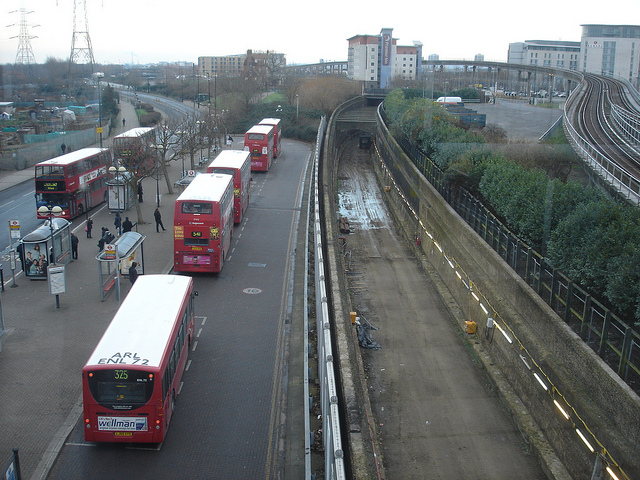

In [ ]:
from IPython.display import Image

print(train_captions[0])
image = Image(train_img_name_vector[0])
display(image)

Οι περιγραφές των εικόνων συνθέτουν ένα κείμενο το οποίο δίνεται στον tf.keras.preprocessing.text.Tokenizer. Αυτός χρησιμοποιεί τις 5000 πιο συχνές λέξεις για να δημιουργήσει ένα λεξικό. Έτσι κάθε λέξη αντιστοιχίζεται σε έναν αριθμό ο οποίος μπορεί πλέον να δωθεί ως είσοδος στο νευρωνικό δίκτυο.

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",
                                                  filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~ \t\n')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

max_length = calc_max_length(train_seqs)
vocab_size = min(top_k, len(tokenizer.word_index))
print(f'vocab_size = {vocab_size}')

vocab_size = 5000


Το 80% του training set χρησιμοποιείται για την εκπαίδευση του μοντέλου ενώ το υπόλοιπο 20% για τον υπολογισμό του validation loss.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(train_img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []

for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])
    
print(f'len(img_name_train) = {len(img_name_train)}')
print(f'len(cap_train) = {len(cap_train)}')
print(f'len(img_name_val) = {len(img_name_val)}')
print(f'len(cap_val) = {len(cap_val)}')

len(img_name_train) = 200104
len(cap_train) = 200104
len(img_name_val) = 50023
len(cap_val) = 50023


## 2 Training and Evaluation

### 2.1 Features

Κάθε εικόνα μετατρέπεται σε εικόνα μεγέθους 299x299 και έχει 3 κανάλια RGB. Περνάει πρώτα απο το προεκπαιδευμένο δίκτυο το οποίο έχει εκπαιδευθεί στην ImageNet. Από αυτό χρησιμοποιείται μόνο το κομμάτι με τα convolutional layers. Τα τελευταία dense layers δεν χρησιμοποιούνται γιατί περιέχουν την εξειδικευμένη γνώση για το classification στις κλάσεις της ImageNet. Κάθε εικόνα περνάει μια φορά μέσα από αυτό το δίκτυο και η έξοδος του αποθηκεύεται στον δίσκο. Αυτά τα αποθηκευμένα features είναι σταθερά για κάθε εικόνα, αφού δεν πρόκεται να ξαναεκπαιδεύσουμε το convolutional κομμάτι του μοντέλου. Έτσι κερδίζουμε σε χρόνο εκπαίδευσης.

In [ ]:
input_shape = (299, 299, 3)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 500
EMBEDDING_DIM = 256
UNITS = 512

In [ ]:
all_data = {}

def set_data(key, data, cnn_name):
    all_data[cnn_name + key] = data

def get_data(key, cnn_name):
    return all_data[cnn_name + key]

In [ ]:
from tqdm import tqdm
import shutil

image_features_folder = 'features'
model_name_to_data = {}

def save_features(cnn_name, cnn_model, load_image_fun):
    image_features_extract_model = tf.keras.Model(cnn_model.input, cnn_model.layers[-1].output)

    if os.path.exists(image_features_folder):
        shutil.rmtree(image_features_folder)

    if not os.path.exists(image_features_folder):
        os.mkdir(image_features_folder)

        encode_train = sorted(set(train_img_name_vector))

        image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
        image_dataset = image_dataset.map(load_image_fun).batch(BATCH_SIZE)

        for img, path in tqdm(image_dataset):
            batch_features = image_features_extract_model(img)
            batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

            for bf, p in zip(batch_features, path):
                path_of_feature = p.numpy().decode("utf-8")
                path_of_feature = os.path.join(image_features_folder, os.path.basename(path_of_feature))
                np.save(path_of_feature, bf.numpy())

    set_data('image_features_extract_model', image_features_extract_model, cnn_name)
    set_data('load_image_fun', load_image_fun, cnn_name)

### 2.2 Model

Το μοντέλο αποτελείται απο δύο μέρη, τον CNN encoder και τον RNN decoder. Ο CNN encoder ρίχει τη διάσταση των αποθηκευμένων features σε 256. Ο RNN decoder χρησιμοποιεί ένα GRU. Έχει ως είσοδο τα features του CNN και την προηγούμενη λέξη που είχε βγάλει ως έξοδο. Στην έξοδο, χρησιμοποιώντας softmax activation function, αποφασίζει ποια είναι η επόμενη λέξη της περιγραφής. Η αντιστοίχιση αριθμού σε λέξη γίνεται με τον tokenizer. Η φράση τελειώνει μόλις εμφανιστεί στην έξοδο η κωδική λέξη <end\>.

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### 2.3 Training

Η εκπαίδευση του μοντέλου γίνεται για 10 εποχές. Με το που τελειώνει η εκπαίδευση το μοντέλο επαναφέρεται στην εποχή που είχε το μικρότερο validation loss. Έτσι αποφεύγεται η υπερπροσαρμογή.

In [ ]:
def loss_function(real, pred, loss_object):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def train_step(img_tensor, target, encoder, decoder, optimizer, loss_object):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions, loss_object)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return (loss / int(target.shape[1]))

def eval_step(img_tensor, target, encoder, decoder, optimizer, loss_object):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions, loss_object)
        dec_input = tf.expand_dims(target[:, i], 1)
            
    return (loss / int(target.shape[1]))

def map_func(img_name, cap):
    filename = img_name.decode('utf-8') + '.npy'
    filename = os.path.join(image_features_folder, os.path.basename(filename))
    img_tensor = np.load(filename)
    return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=BUFFER_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

results = []
results_pickle = '/content/drive/MyDrive/results.pkl'

def new_results():
    results.append([])

def add_to_results(key, val):
    results[-1].append((key, val))

def save_results():
    with open(results_pickle, 'wb') as pickle_file:
        pickle.dump(results, pickle_file)

def load_results():
    with open(results_pickle, 'rb') as pickle_file:
        global results
        results = pickle.load(pickle_file)

load_results()

for res in results:
    for key, val in res:
        print(f'{key}: {val}')
    print()

Model: Xception
Training time: 6897.51438164711
Bleu_1: 0.42154122234875213
Bleu_2: 0.24583784452275315
Bleu_3: 0.13545442077395967
Bleu_4: 0.07248090030408545
METEOR: 0.14289081579976162
ROUGE_L: 0.33060801028652376
CIDEr: 0.23326709986432384
SPICE: 0.07340389394021651
Prediction time: 0.24618077278137207

Model: VGG16
Training time: 5486.5678770542145
Bleu_1: 0.39797417067611385
Bleu_2: 0.23063577350631334
Bleu_3: 0.12646249561302353
Bleu_4: 0.06801212705814819
METEOR: 0.13442316319157038
ROUGE_L: 0.3145383416693452
CIDEr: 0.18314130934056924
SPICE: 0.06522420429003578
Prediction time: 0.12398076057434082

Model: ResNet152V2
Training time: 6199.127720832825
Bleu_1: 0.42299129009849096
Bleu_2: 0.25084639528351604
Bleu_3: 0.14319174357830455
Bleu_4: 0.07922166865435994
METEOR: 0.14123210750024087
ROUGE_L: 0.326326873005035
CIDEr: 0.22994190127206912
SPICE: 0.07352283348870403
Prediction time: 0.2499098777770996

Model: InceptionV3
Training time: 5283.9419758319855
Bleu_1: 0.41255745382

In [ ]:
import matplotlib.pyplot as plt

def train_model(cnn_name):
    t0 = time.time()

    encoder = CNN_Encoder(EMBEDDING_DIM)
    decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size)

    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    EPOCHS = 10
    epochs = range(1, EPOCHS+1)
    loss_plot = []
    v_loss_plot = []
    best_v_loss = None
    best_epoch = None
    checkpoints_folder = 'checkpoints'

    if os.path.exists(checkpoints_folder):
        shutil.rmtree(checkpoints_folder)

    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoints_folder, max_to_keep=None)

    train_step_fun = tf.function(train_step)
    eval_step_fun = tf.function(eval_step)

    for epoch in epochs:
        t1 = time.time()
        total_loss = 0
        total_v_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            total_loss += train_step_fun(img_tensor, target, encoder, decoder, optimizer, loss_object)
        avg_loss = total_loss / len(dataset)
        loss_plot.append(avg_loss)
        
        for (batch, (img_tensor, target)) in enumerate(val_dataset):
            total_v_loss += eval_step_fun(img_tensor, target, encoder, decoder, optimizer, loss_object)
        avg_v_loss = total_v_loss / len(val_dataset)
        v_loss_plot.append(avg_v_loss)
        
        if best_v_loss is None or avg_v_loss < best_v_loss:
            best_v_loss = avg_v_loss
            best_epoch = epoch
            ckpt_manager.save(checkpoint_number=epoch+1)
        
        print(f'Epoch {epoch:02d}: loss = {avg_loss:.4f}, val_loss = {avg_v_loss:.4f}, t = {(time.time() - t1)/60:.1f} min')

    t = time.time() - t0
    print(f'Total training time: {t/60:.1f} min')

    print(f'Restoring model to epoch: {best_epoch}')
    ckpt.restore(ckpt_manager.latest_checkpoint)

    new_results()
    add_to_results('Model', cnn_name)
    add_to_results('Training time', t)

    set_data('encoder', encoder, cnn_name)
    set_data('decoder', decoder, cnn_name)

    plt.plot(epochs, loss_plot, label='Training loss')
    plt.plot(epochs, v_loss_plot, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.legend()
    plt.show()

### 2.4 Evaluation

Γίνεται αξιολόγηση του μοντέλου πάνω σε 5000 εικόνες του validation set που δεν έχουν χρησιμοποιηθεί καθόλου στην εκπαίδευση. Η αξιολόγηση γίνεται χρησιμοποιώντας τις μετρικές BLEU, Meteor, Rouge-L, CIDEr και SPICE χρησιμοποιώντας την βιβλιοθήκη pycocoevalcap. Επίσης εμφανίζεται μια τυχαία εικόνα από το validation set, τα true caption της, το predicted caption και το attention plot, δηλαδη τα μέρη της εικόνας τα οποία επηρέασαν περισσότερο το μόντελο για να αποφασίσει την κάθε λέξη της φράσης. Το ίδιο γίνεται με μια τυχαία εικόνα απο το test set και με μια συγκεκριμένη εικόνα ενός surfer.

In [ ]:
val_size = 5000

In [ ]:
val_image_id_to_caption = collections.defaultdict(list)

for val in val_annotations['annotations']:
    image_id = val['image_id']
    caption = val['caption']
    val_image_id_to_caption[image_id].append(caption)
    
val_image_ids = sorted(list(val_image_id_to_caption.keys()))
np.random.shuffle(val_image_ids)
val_image_ids = val_image_ids[:val_size]

In [ ]:
!pip install pycocoevalcap

In [ ]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

def predict_image_caption(image_path, image_features_extract_model,
                          load_image_fun, encoder, decoder):
    temp_input = tf.expand_dims(load_image_fun(image_path)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    result = []
    hidden = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            break
        dec_input = tf.expand_dims([predicted_id], 0)
    result = ' '.join(result)

    return result

def create_results_file(cnn_name):
    image_features_extract_model = get_data('image_features_extract_model', cnn_name)
    load_image_fun = get_data('load_image_fun', cnn_name)
    encoder = get_data('encoder', cnn_name)
    decoder = get_data('decoder', cnn_name)
    json_data = []

    for image_id in tqdm(val_image_ids):
        image_path = os.path.join(val_image_folder, 'COCO_val2014_%012d.jpg' % (image_id))
        result = predict_image_caption(image_path, image_features_extract_model,
                                       load_image_fun, encoder, decoder)
        json_data.append({'image_id': image_id, 'caption': result})

    results_file = 'captions_val2014_results.json'
    with open(results_file, 'w') as outfile:
        json.dump(json_data, outfile)
    
    return results_file

def coco_eval_results_file(results_file, cnn_name):
    coco = COCO(val_annotation_file)
    coco_result = coco.loadRes(results_file)

    coco_eval = COCOEvalCap(coco, coco_result)
    coco_eval.params['image_id'] = coco_result.getImgIds()
    coco_eval.evaluate()

    print()
    for metric, score in coco_eval.eval.items():
        add_to_results(metric, score)
        print(f'{metric}: {score:.4f}')

def evaluate_model_on_validation_set(cnn_name):
    results_file = create_results_file(cnn_name)
    coco_eval_results_file(results_file, cnn_name)

In [ ]:
import PIL

def plot_attention(image, result, attention_plot):
    temp_image = np.array(PIL.Image.open(image))

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

def evaluate_image(image, cnn_name):
    image_features_extract_model = get_data('image_features_extract_model', cnn_name)
    load_image_fun = get_data('load_image_fun', cnn_name)
    encoder = get_data('encoder', cnn_name)
    decoder = get_data('decoder', cnn_name)

    output = image_features_extract_model.layers[-1].output
    attention_features_shape = output.shape[1] * output.shape[2]
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_fun(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

rid = np.random.randint(0, len(val_image_ids))
val_image_id = val_image_ids[rid]

def evaluate_model_on_validation_image(cnn_name):
    image_path = os.path.join(val_image_folder, 'COCO_val2014_%012d.jpg' % (val_image_id))
    real_captions = val_image_id_to_caption[val_image_id]
    result, attention_plot = evaluate_image(image_path, cnn_name)

    for real_caption in real_captions:
        print('True caption:', real_caption)
    print('Predicted caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    display(Image(image_path))

In [ ]:
test_image_paths = []

for image_path in os.listdir(test_image_folder):
    image_path = os.path.join(test_image_folder, image_path)
    test_image_paths.append(image_path)

In [ ]:
rid = np.random.randint(0, len(test_image_paths))
test_image_path = test_image_paths[rid]

def evaluate_model_on_test_image(cnn_name):
    result, attention_plot = evaluate_image(test_image_path, cnn_name)

    print('Predicted caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    display(Image(image_path))

def evaluate_model_on_test_set(cnn_name):
    evaluate_model_on_test_image(cnn_name)

In [ ]:
def evaluate_model_on_surf_image(cnn_name):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_extension = image_url[-4:]
    image_path = tf.keras.utils.get_file('image' + image_extension, origin=image_url)

    t0 = time.time()
    result, attention_plot = evaluate_image(image_path, cnn_name)
    t = time.time() - t0
    add_to_results('Prediction time', t)
    save_results()
    print('Predicted caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    display(Image(image_path))

## 3 Models

Παρακάτω γίνεται εκπαίδευση και αξιολόγηση του μοντέλου χρησιμοποιώντας κάθε φορά διαφορετικό προεκπαιδευμένο CNN.

### 3.1 Xception

In [ ]:
def load_image_Xception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('Xception', tf.keras.applications.Xception(include_top=False, input_shape=input_shape),
            load_image_Xception)

100%|██████████| 782/782 [08:25<00:00,  1.55it/s]


Epoch 01: loss = 0.7164, val_loss = 0.6574, t = 13.4 min
Epoch 02: loss = 0.6154, val_loss = 0.6356, t = 11.3 min
Epoch 03: loss = 0.5811, val_loss = 0.6304, t = 11.3 min
Epoch 04: loss = 0.5563, val_loss = 0.6304, t = 11.2 min
Epoch 05: loss = 0.5366, val_loss = 0.6354, t = 11.3 min
Epoch 06: loss = 0.5195, val_loss = 0.6414, t = 11.2 min
Epoch 07: loss = 0.5045, val_loss = 0.6514, t = 11.2 min
Epoch 08: loss = 0.4908, val_loss = 0.6597, t = 11.4 min
Epoch 09: loss = 0.4783, val_loss = 0.6729, t = 11.3 min
Epoch 10: loss = 0.4668, val_loss = 0.6820, t = 11.3 min
Total training time: 115.0 min
Restoring model to epoch: 3


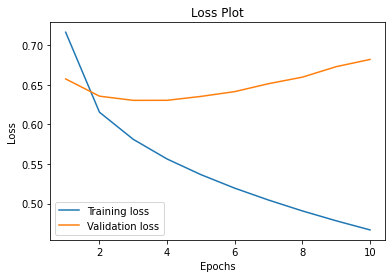

In [ ]:
train_model('Xception')

In [ ]:
evaluate_model_on_validation_set('Xception')

100%|██████████| 5000/5000 [20:37<00:00,  4.04it/s]


loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 57954, 'reflen': 52759, 'guess': [57954, 52954, 47954, 42954], 'correct': [24430, 7592, 1972, 477]}
ratio: 1.0984666123315245
Bleu_1: 0.422
Bleu_2: 0.246
Bleu_3: 0.135
Bleu_4: 0.072
computing METEOR score...
METEOR: 0.143
computing Rouge score...
ROUGE_L: 0.331
computing CIDEr score...
CIDEr: 0.233
computing SPICE score...
SPICE: 0.073

Bleu_1: 0.4215
Bleu_2: 0.2458
Bleu_3: 0.1355
Bleu_4: 0.0725
METEOR: 0.1429
ROUGE_L: 0.3306
CIDEr: 0.2333
SPICE: 0.0734


True caption: A bird that is playing in the snow.
True caption: A grey bird in the middle of a snow-covered ground

True caption: A small bird sitting on top of a sandy beach.
True caption: A small bird is standing in the snow.
True caption: A small bird standing on the snowy ground.
Predicted caption: two wild stripped bare plants standing on some grass <end>


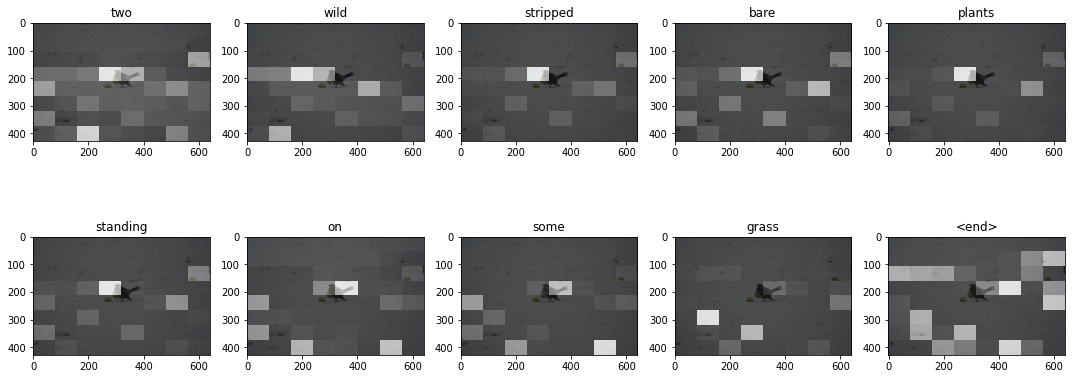

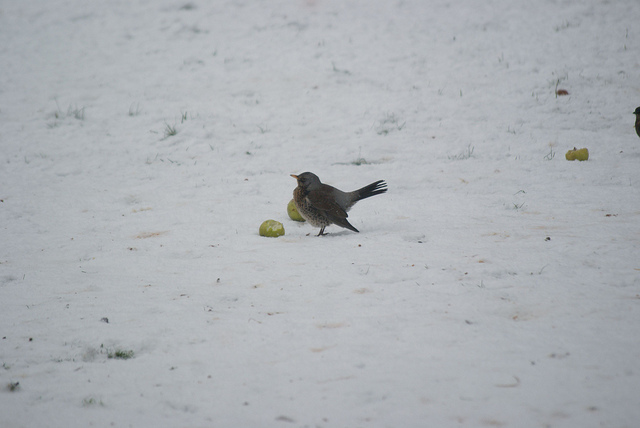

In [ ]:
evaluate_model_on_validation_image('Xception')

Predicted caption: a second teddy bear stands in a store <end>


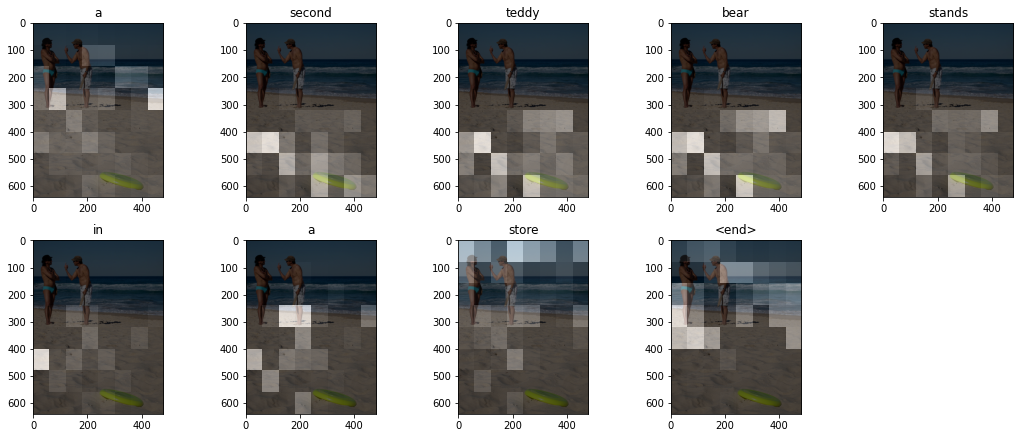

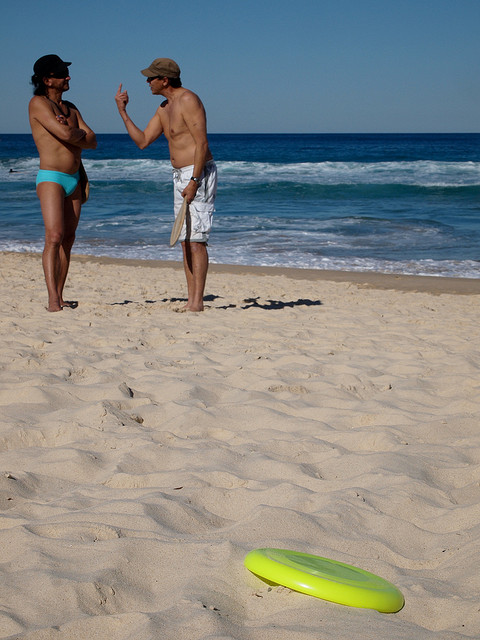

In [ ]:
evaluate_model_on_test_image('Xception')

Predicted caption: a man riding a wave in a surf board <end>


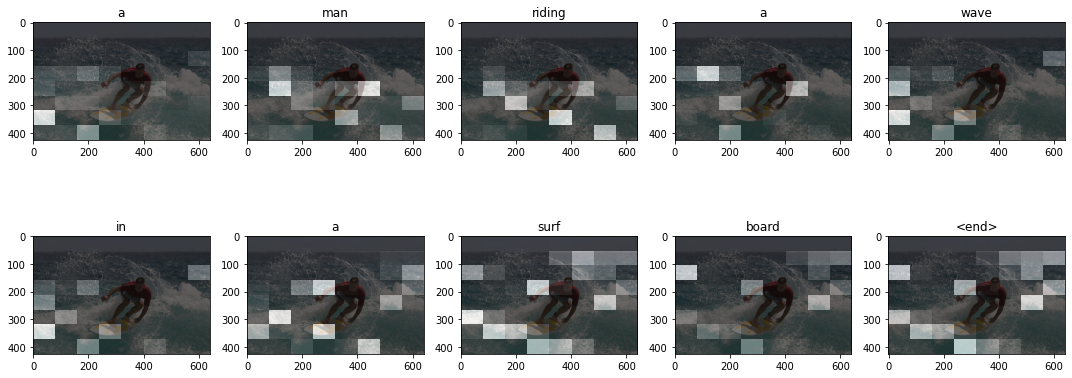

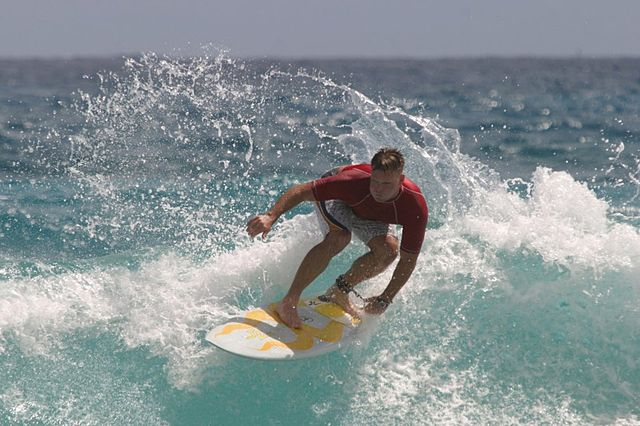

In [ ]:
evaluate_model_on_surf_image('Xception')

### 3.2 VGG16

In [ ]:
def load_image_VGG16(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('VGG16', tf.keras.applications.VGG16(include_top=False, input_shape=input_shape),
            load_image_VGG16)

100%|██████████| 782/782 [09:55<00:00,  1.31it/s]


Epoch 01: loss = 0.7384, val_loss = 0.6722, t = 11.3 min
Epoch 02: loss = 0.6273, val_loss = 0.6459, t = 8.9 min
Epoch 03: loss = 0.5956, val_loss = 0.6424, t = 8.9 min
Epoch 04: loss = 0.5749, val_loss = 0.6436, t = 8.9 min
Epoch 05: loss = 0.5587, val_loss = 0.6436, t = 8.9 min
Epoch 06: loss = 0.5452, val_loss = 0.6480, t = 8.9 min
Epoch 07: loss = 0.5330, val_loss = 0.6511, t = 8.9 min
Epoch 08: loss = 0.5218, val_loss = 0.6595, t = 8.9 min
Epoch 09: loss = 0.5124, val_loss = 0.6642, t = 8.9 min
Epoch 10: loss = 0.5034, val_loss = 0.6713, t = 8.8 min
Total training time: 91.4 min
Restoring model to epoch: 3


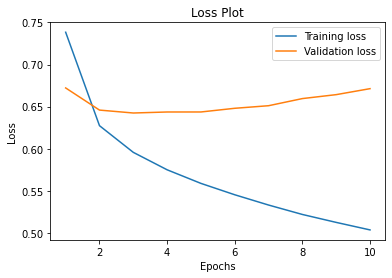

In [ ]:
train_model('VGG16')

In [ ]:
evaluate_model_on_validation_set('VGG16')

100%|██████████| 5000/5000 [16:52<00:00,  4.94it/s]


loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 59235, 'reflen': 52200, 'guess': [59235, 54235, 49235, 44237], 'correct': [23574, 7249, 1872, 468]}
ratio: 1.1347701149425071
Bleu_1: 0.398
Bleu_2: 0.231
Bleu_3: 0.126
Bleu_4: 0.068
computing METEOR score...
METEOR: 0.134
computing Rouge score...
ROUGE_L: 0.315
computing CIDEr score...
CIDEr: 0.183
computing SPICE score...
SPICE: 0.065

Bleu_1: 0.3980
Bleu_2: 0.2306
Bleu_3: 0.1265
Bleu_4: 0.0680
METEOR: 0.1344
ROUGE_L: 0.3145
CIDEr: 0.1831
SPICE: 0.0652


True caption: A bird that is playing in the snow.
True caption: A grey bird in the middle of a snow-covered ground

True caption: A small bird sitting on top of a sandy beach.
True caption: A small bird is standing in the snow.
True caption: A small bird standing on the snowy ground.
Predicted caption: a group of birds with a pink frisbee <end>


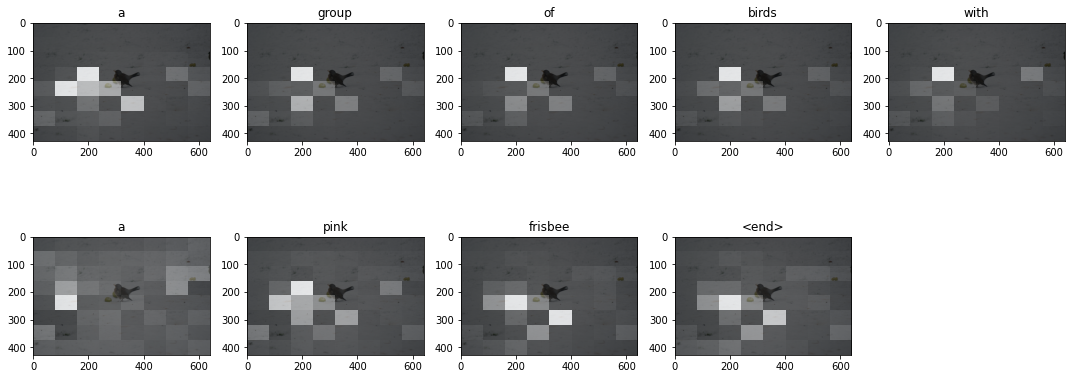

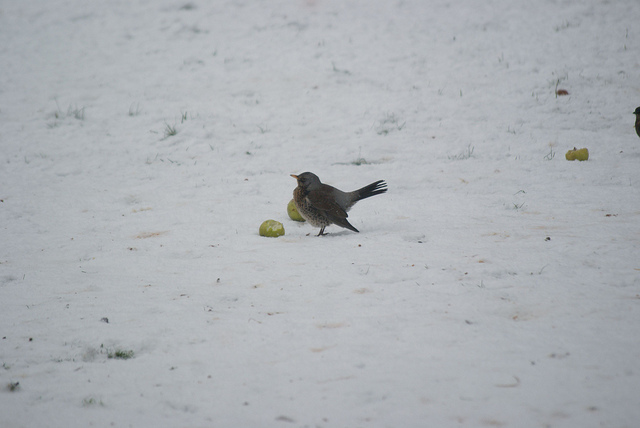

In [ ]:
evaluate_model_on_validation_image('VGG16')

Predicted caption: a lot of teddy bears and a small lamp of a store window with a big great shower thats ornaments on display conveyor is displayed in a pin <end>


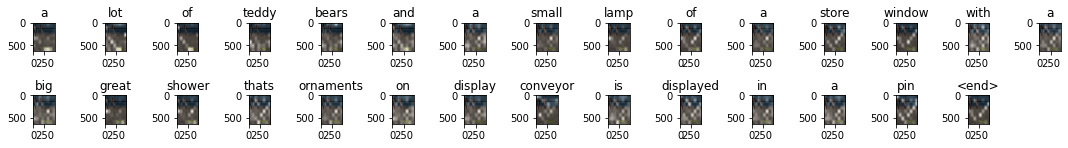

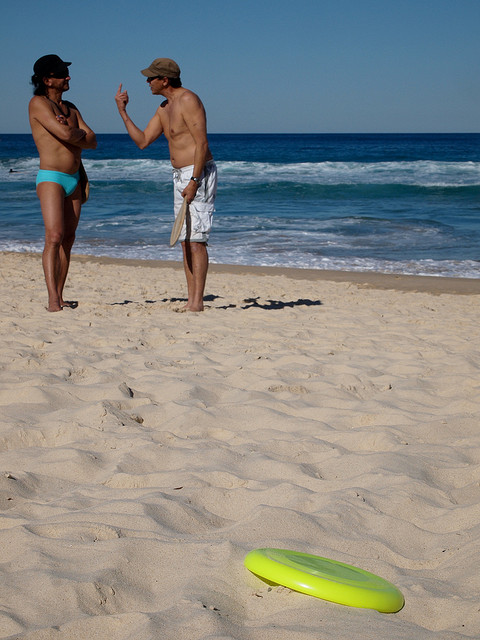

In [ ]:
evaluate_model_on_test_image('VGG16')

Predicted caption: she entering the ocean wave <end>


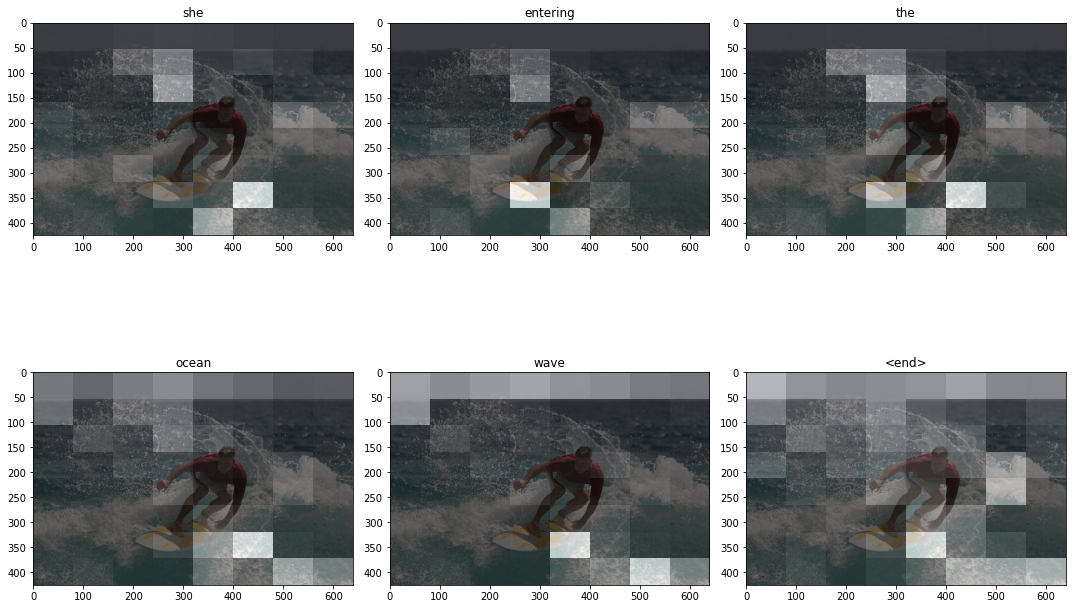

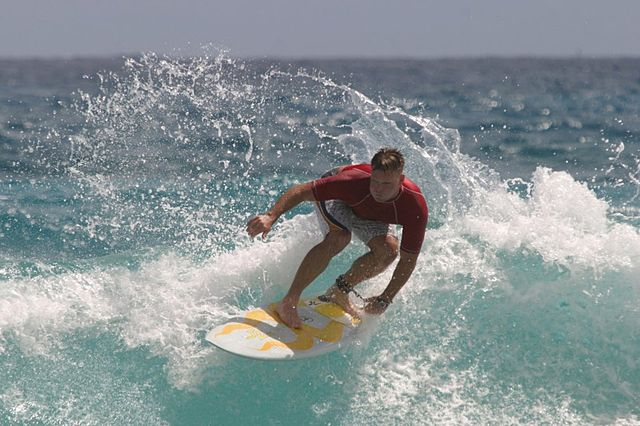

In [ ]:
evaluate_model_on_surf_image('VGG16')

### 3.3 ResNet152V2

In [ ]:
def load_image_ResNet152V2(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('ResNet152V2', tf.keras.applications.ResNet152V2(include_top=False, input_shape=input_shape),
            load_image_ResNet152V2)

234553344/234545216 [==============================] - 5s 0us/step


100%|██████████| 782/782 [08:45<00:00,  1.49it/s]


Epoch 01: loss = 0.7155, val_loss = 0.6507, t = 11.2 min
Epoch 02: loss = 0.6061, val_loss = 0.6301, t = 10.1 min
Epoch 03: loss = 0.5717, val_loss = 0.6251, t = 10.3 min
Epoch 04: loss = 0.5473, val_loss = 0.6262, t = 10.3 min
Epoch 05: loss = 0.5280, val_loss = 0.6310, t = 10.3 min
Epoch 06: loss = 0.5117, val_loss = 0.6386, t = 10.3 min
Epoch 07: loss = 0.4972, val_loss = 0.6482, t = 10.3 min
Epoch 08: loss = 0.4845, val_loss = 0.6569, t = 10.3 min
Epoch 09: loss = 0.4726, val_loss = 0.6665, t = 10.3 min
Epoch 10: loss = 0.4621, val_loss = 0.6755, t = 10.3 min
Total training time: 103.3 min
Restoring model to epoch: 3


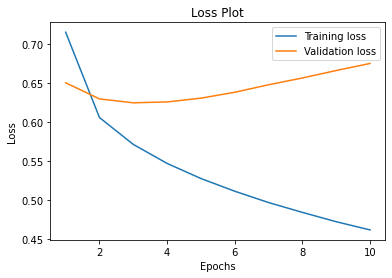

In [ ]:
train_model('ResNet152V2')

In [ ]:
evaluate_model_on_validation_set('ResNet152V2')

100%|██████████| 5000/5000 [23:49<00:00,  3.50it/s]


loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 56143, 'reflen': 51577, 'guess': [56143, 51143, 46143, 41145], 'correct': [23748, 7608, 2153, 552]}
ratio: 1.0885278321732346
Bleu_1: 0.423
Bleu_2: 0.251
Bleu_3: 0.143
Bleu_4: 0.079
computing METEOR score...
METEOR: 0.141
computing Rouge score...
ROUGE_L: 0.326
computing CIDEr score...
CIDEr: 0.230
computing SPICE score...
SPICE: 0.074

Bleu_1: 0.4230
Bleu_2: 0.2508
Bleu_3: 0.1432
Bleu_4: 0.0792
METEOR: 0.1412
ROUGE_L: 0.3263
CIDEr: 0.2299
SPICE: 0.0735


True caption: A bird that is playing in the snow.
True caption: A grey bird in the middle of a snow-covered ground

True caption: A small bird sitting on top of a sandy beach.
True caption: A small bird is standing in the snow.
True caption: A small bird standing on the snowy ground.
Predicted caption: two birds sitting on a beach <end>


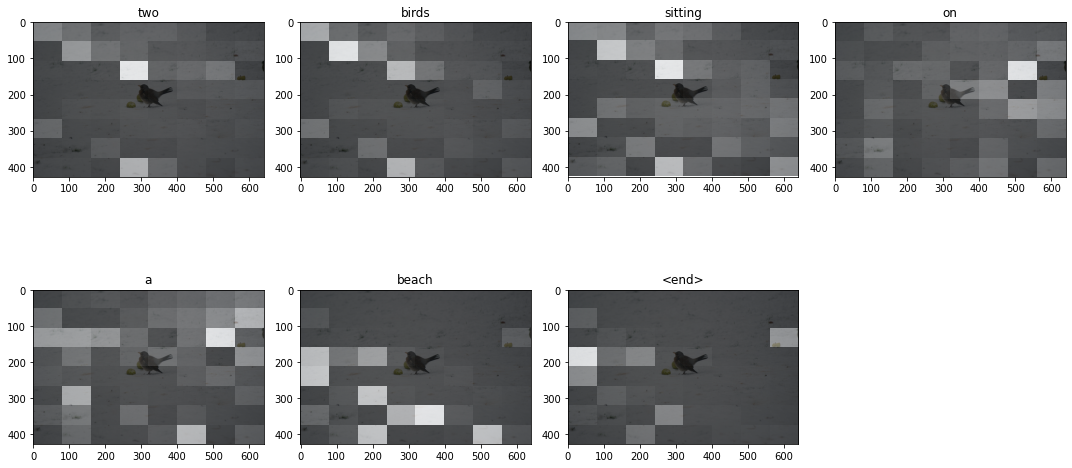

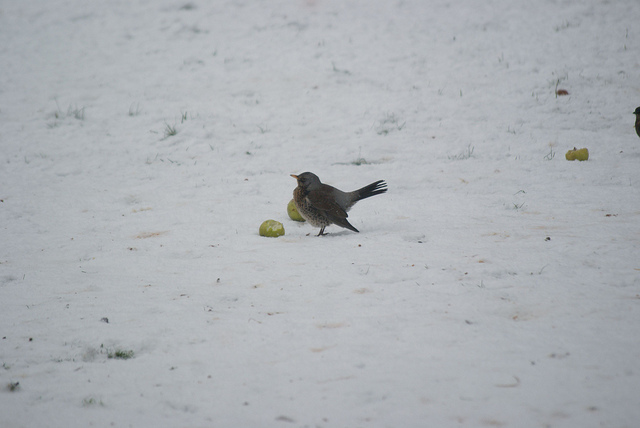

In [ ]:
evaluate_model_on_validation_image('ResNet152V2')

Predicted caption: a man walks near a metal pole <end>


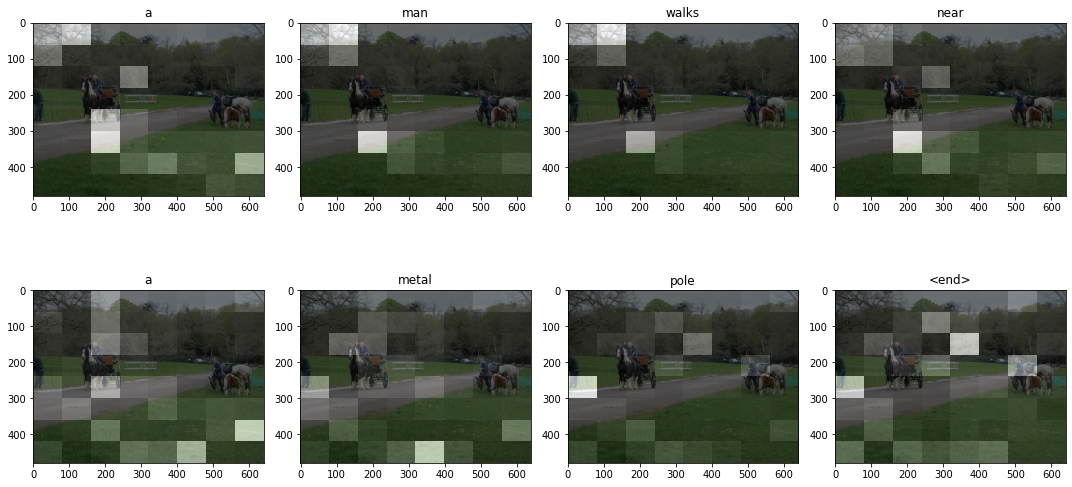

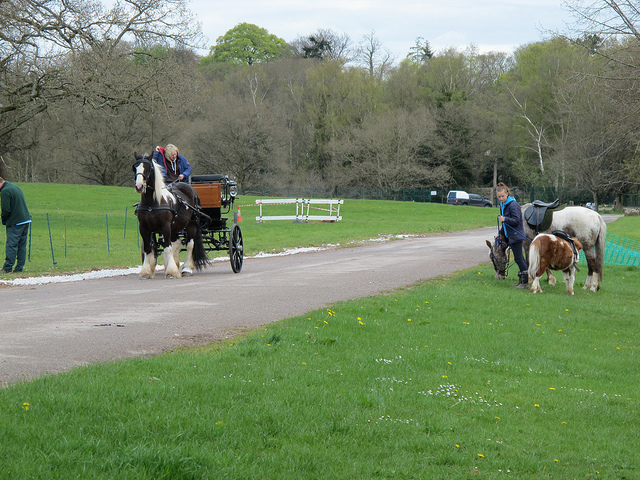

In [ ]:
evaluate_model_on_test_image('ResNet152V2')

65536/64400 [==============================] - 0s 3us/step
Predicted caption: a man on surf on the shore <end>


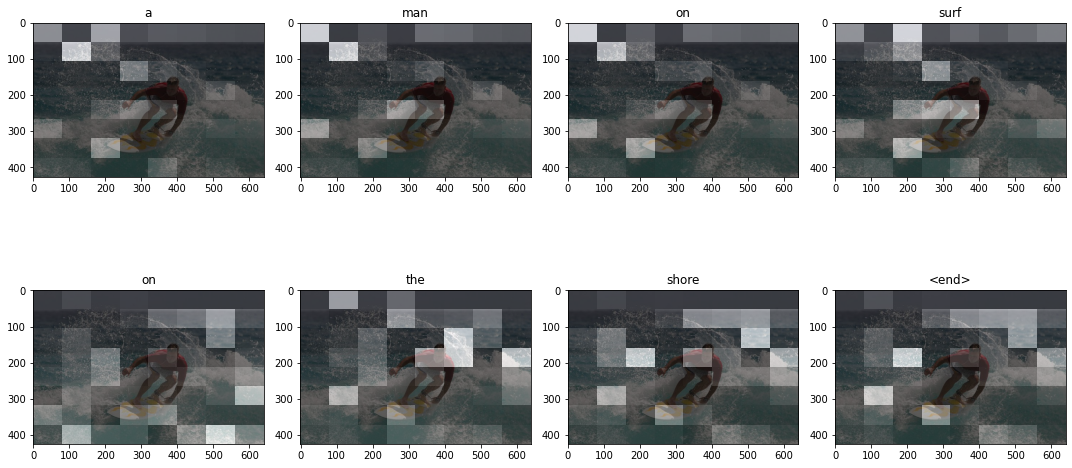

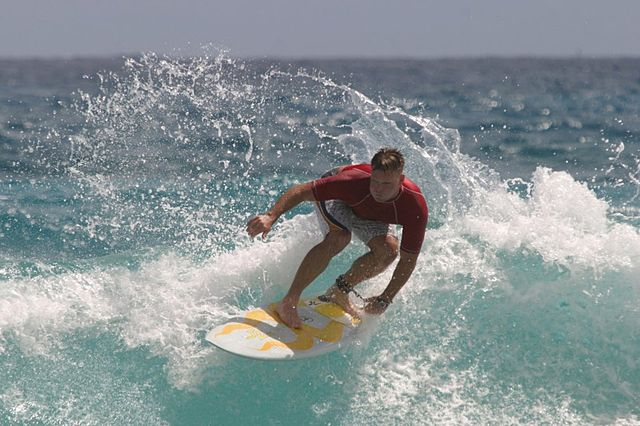

In [ ]:
evaluate_model_on_surf_image('ResNet152V2')

### 3.4 InceptionV3

In [ ]:
def load_image_InceptionV3(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('InceptionV3', tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape),
            load_image_InceptionV3)

87916544/87910968 [==============================] - 2s 0us/step


100%|██████████| 782/782 [06:44<00:00,  1.93it/s]


Epoch 01: loss = 0.7244, val_loss = 0.6640, t = 10.7 min
Epoch 02: loss = 0.6232, val_loss = 0.6399, t = 8.6 min
Epoch 03: loss = 0.5920, val_loss = 0.6315, t = 8.6 min
Epoch 04: loss = 0.5707, val_loss = 0.6301, t = 8.6 min
Epoch 05: loss = 0.5536, val_loss = 0.6357, t = 8.5 min
Epoch 06: loss = 0.5386, val_loss = 0.6409, t = 8.6 min
Epoch 07: loss = 0.5251, val_loss = 0.6477, t = 8.5 min
Epoch 08: loss = 0.5124, val_loss = 0.6546, t = 8.6 min
Epoch 09: loss = 0.5008, val_loss = 0.6645, t = 8.6 min
Epoch 10: loss = 0.4903, val_loss = 0.6733, t = 8.6 min
Total training time: 88.1 min
Restoring model to epoch: 4


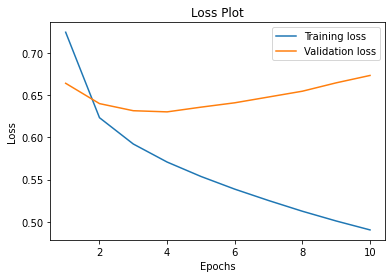

In [ ]:
train_model('InceptionV3')

In [ ]:
evaluate_model_on_validation_set('InceptionV3')

100%|██████████| 5000/5000 [18:12<00:00,  4.58it/s]


loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 57655, 'reflen': 52498, 'guess': [57655, 52655, 47655, 42657], 'correct': [23786, 7394, 2010, 480]}
ratio: 1.0982323136119263
Bleu_1: 0.413
Bleu_2: 0.241
Bleu_3: 0.135
Bleu_4: 0.072
computing METEOR score...
METEOR: 0.140
computing Rouge score...
ROUGE_L: 0.321
computing CIDEr score...
CIDEr: 0.225
computing SPICE score...
SPICE: 0.072

Bleu_1: 0.4126
Bleu_2: 0.2407
Bleu_3: 0.1347
Bleu_4: 0.0724
METEOR: 0.1403
ROUGE_L: 0.3215
CIDEr: 0.2252
SPICE: 0.0725


True caption: A bird that is playing in the snow.
True caption: A grey bird in the middle of a snow-covered ground

True caption: A small bird sitting on top of a sandy beach.
True caption: A small bird is standing in the snow.
True caption: A small bird standing on the snowy ground.
Predicted caption: a bird in a folding chair <end>


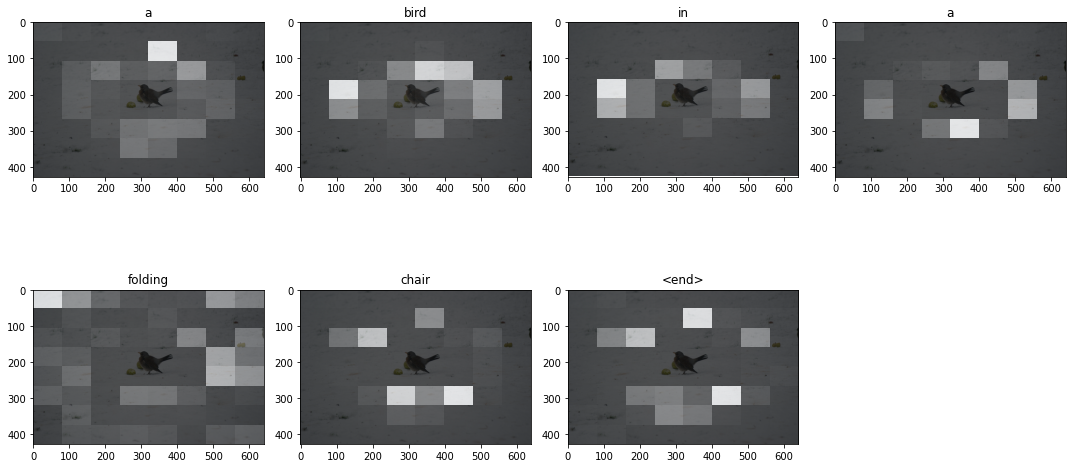

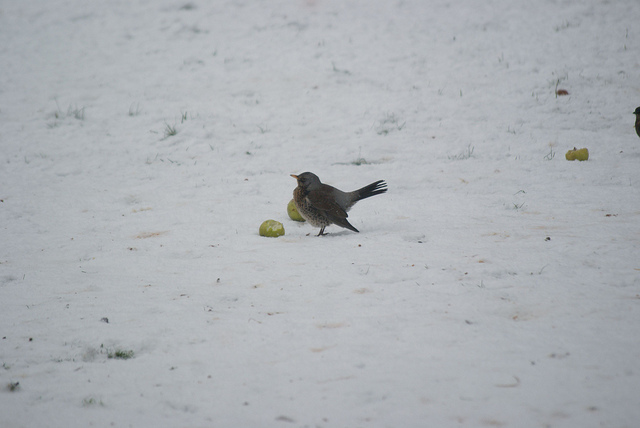

In [ ]:
evaluate_model_on_validation_image('InceptionV3')

Predicted caption: a person with a woman walking through frozen <end>


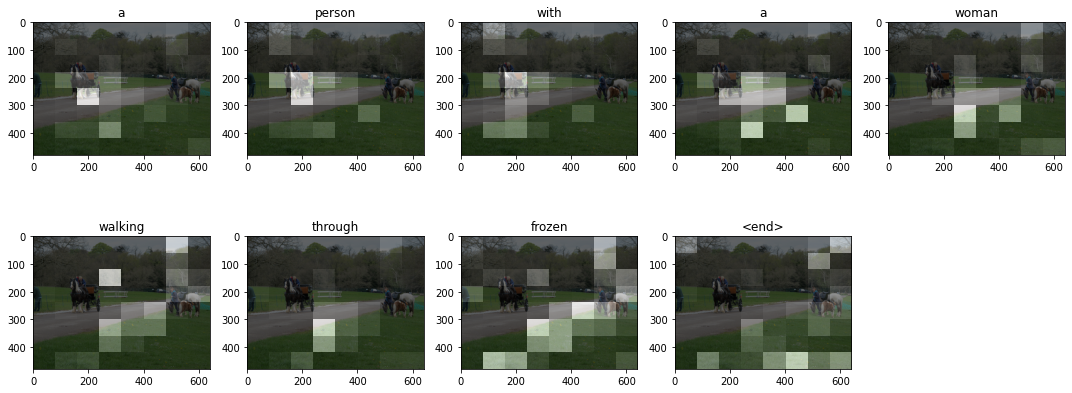

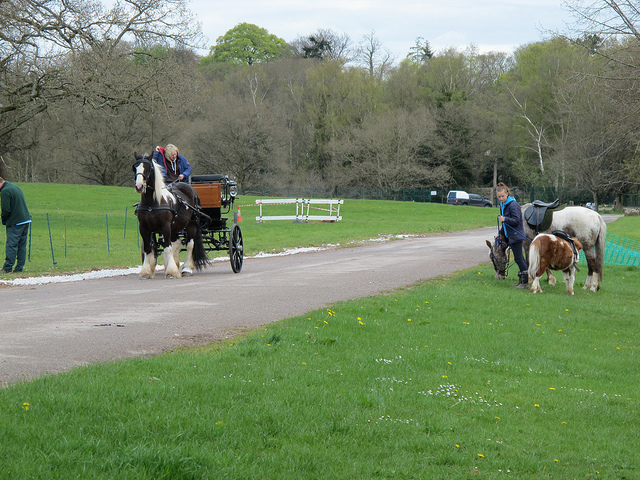

In [ ]:
evaluate_model_on_test_image('InceptionV3')

Predicted caption: a surfer rides a wave on a wave <end>


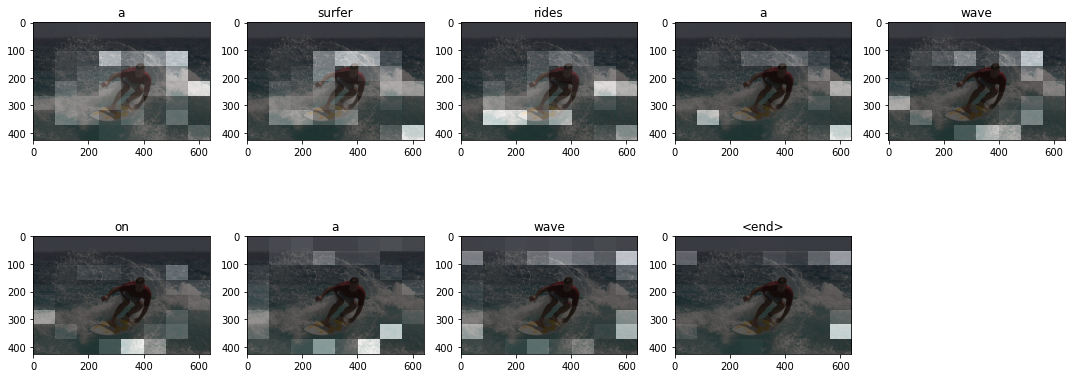

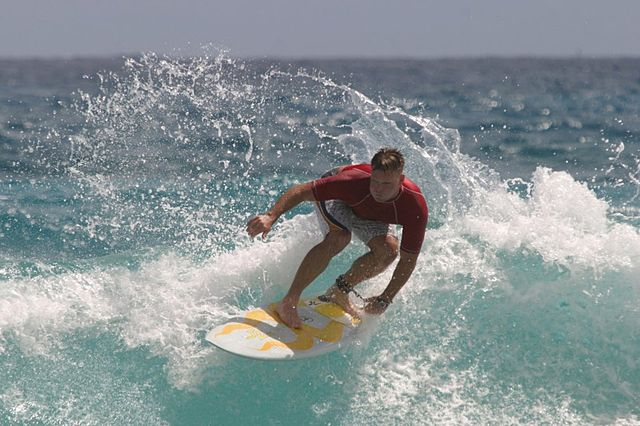

In [ ]:
evaluate_model_on_surf_image('InceptionV3')

### 3.5 InceptionResNetV2

In [ ]:
def load_image_InceptionResNetV2(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('InceptionResNetV2', tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=input_shape),
            load_image_InceptionResNetV2)

100%|██████████| 782/782 [06:50<00:00,  1.90it/s]


Epoch 01: loss = 0.7253, val_loss = 0.6635, t = 9.8 min
Epoch 02: loss = 0.6222, val_loss = 0.6368, t = 8.2 min
Epoch 03: loss = 0.5908, val_loss = 0.6289, t = 8.3 min
Epoch 04: loss = 0.5697, val_loss = 0.6276, t = 8.1 min
Epoch 05: loss = 0.5524, val_loss = 0.6288, t = 8.1 min
Epoch 06: loss = 0.5377, val_loss = 0.6348, t = 8.0 min
Epoch 07: loss = 0.5250, val_loss = 0.6396, t = 7.9 min
Epoch 08: loss = 0.5124, val_loss = 0.6483, t = 8.1 min
Epoch 09: loss = 0.5012, val_loss = 0.6575, t = 8.1 min
Epoch 10: loss = 0.4910, val_loss = 0.6660, t = 8.0 min
Total training time: 82.5 min
Restoring model to epoch: 4


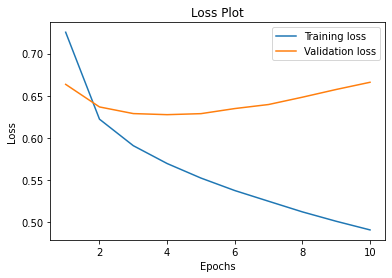

In [ ]:
train_model('InceptionResNetV2')

In [ ]:
evaluate_model_on_validation_set('InceptionResNetV2')

100%|██████████| 5000/5000 [28:42<00:00,  2.90it/s]


loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 57439, 'reflen': 51675, 'guess': [57439, 52439, 47439, 42444], 'correct': [23950, 7734, 2169, 545]}
ratio: 1.1115432994678063
Bleu_1: 0.417
Bleu_2: 0.248
Bleu_3: 0.141
Bleu_4: 0.078
computing METEOR score...
METEOR: 0.142
computing Rouge score...
ROUGE_L: 0.324
computing CIDEr score...
CIDEr: 0.221
computing SPICE score...
SPICE: 0.072

Bleu_1: 0.4170
Bleu_2: 0.2480
Bleu_3: 0.1411
Bleu_4: 0.0775
METEOR: 0.1416
ROUGE_L: 0.3243
CIDEr: 0.2215
SPICE: 0.0724


True caption: A bird that is playing in the snow.
True caption: A grey bird in the middle of a snow-covered ground

True caption: A small bird sitting on top of a sandy beach.
True caption: A small bird is standing in the snow.
True caption: A small bird standing on the snowy ground.
Predicted caption: a small bird sitting on a ledge <end>


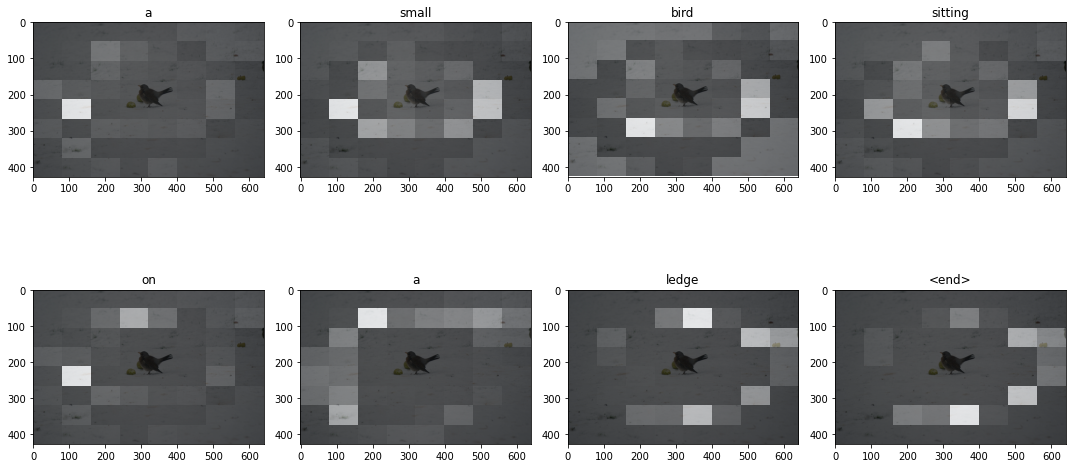

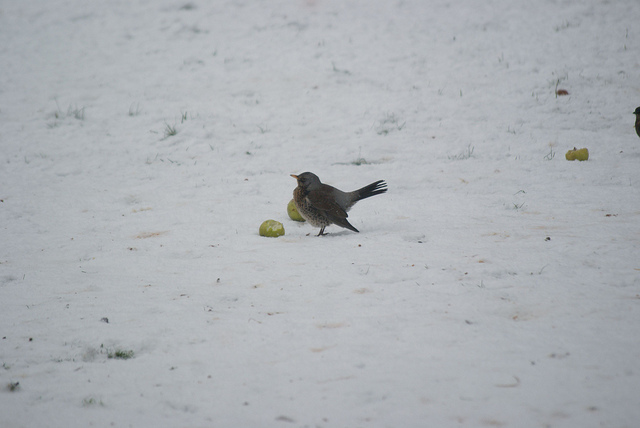

In [ ]:
evaluate_model_on_validation_image('InceptionResNetV2')

Predicted caption: a man walks down a area <end>


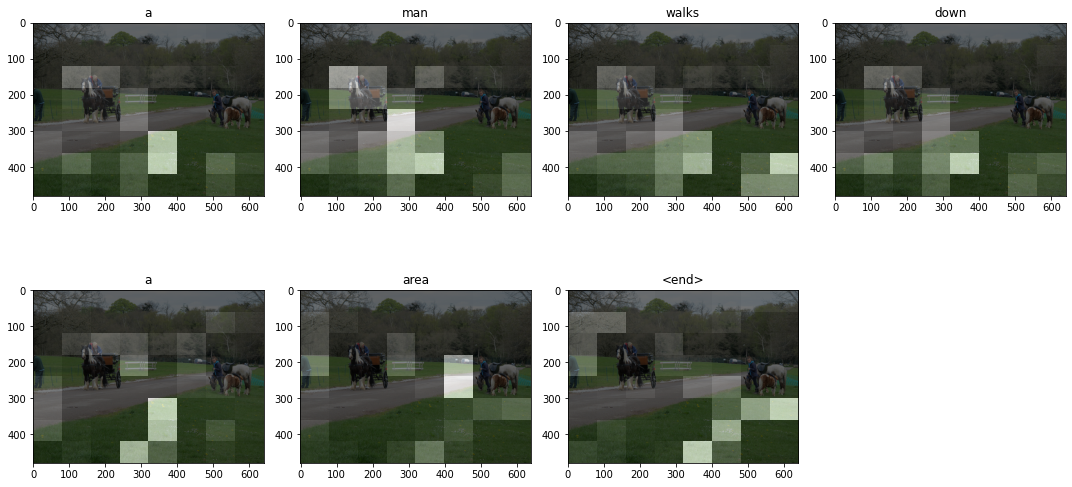

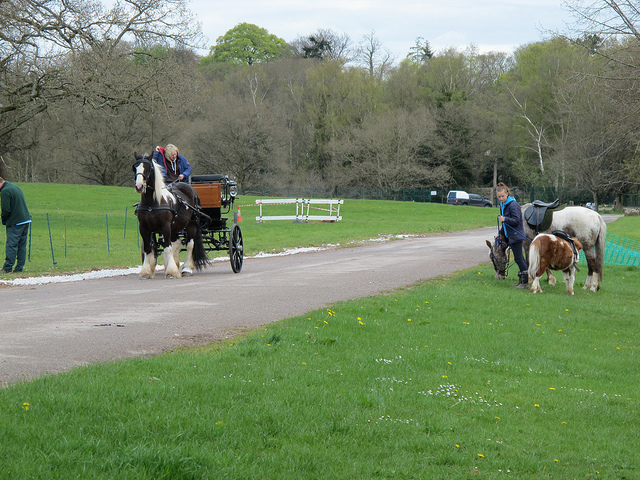

In [ ]:
evaluate_model_on_test_image('InceptionResNetV2')

Predicted caption: a female surfer balances on <unk> <end>


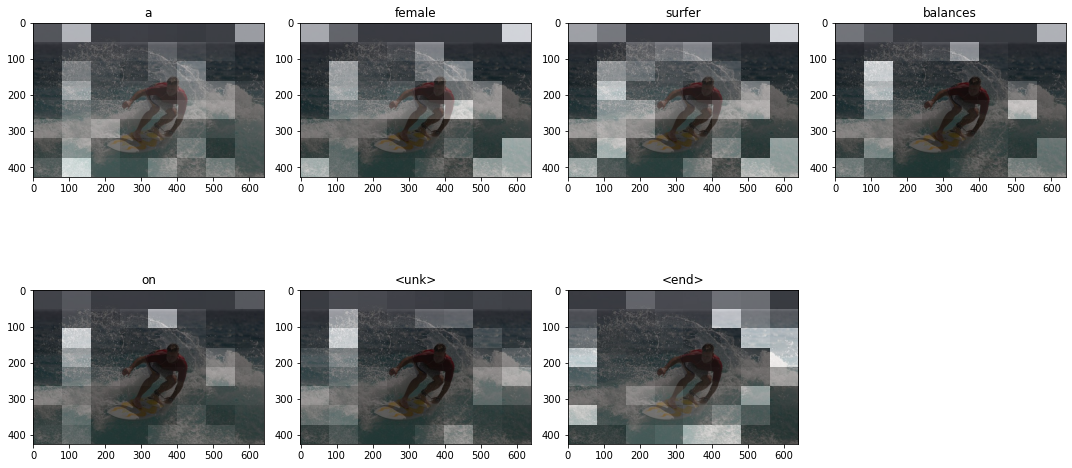

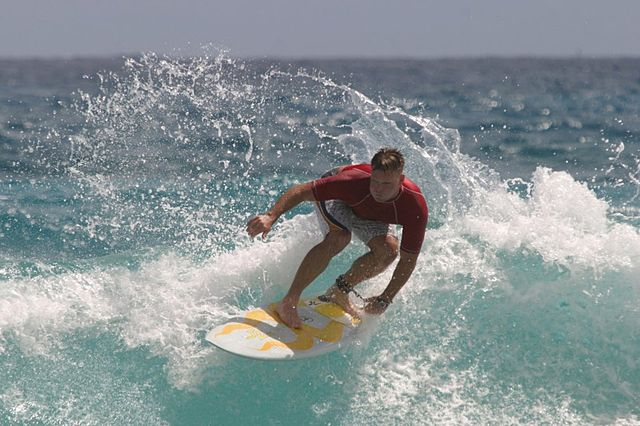

In [ ]:
evaluate_model_on_surf_image('InceptionResNetV2')

### 3.6 MobileNetV2

In [ ]:
def load_image_MobileNetV2(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, input_shape[:2])
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, image_path

In [ ]:
save_features('MobileNetV2', tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape),
            load_image_MobileNetV2)

9412608/9406464 [==============================] - 0s 0us/step


100%|██████████| 782/782 [06:37<00:00,  1.97it/s]


Epoch 01: loss = 0.7205, val_loss = 0.6572, t = 10.4 min
Epoch 02: loss = 0.6123, val_loss = 0.6353, t = 8.3 min
Epoch 03: loss = 0.5775, val_loss = 0.6315, t = 8.2 min
Epoch 04: loss = 0.5535, val_loss = 0.6343, t = 8.2 min
Epoch 05: loss = 0.5339, val_loss = 0.6401, t = 8.1 min
Epoch 06: loss = 0.5169, val_loss = 0.6475, t = 8.1 min
Epoch 07: loss = 0.5020, val_loss = 0.6579, t = 8.1 min
Epoch 08: loss = 0.4885, val_loss = 0.6682, t = 8.0 min
Epoch 09: loss = 0.4770, val_loss = 0.6757, t = 8.1 min
Epoch 10: loss = 0.4660, val_loss = 0.6874, t = 8.1 min
Total training time: 83.7 min
Restoring model to epoch: 3


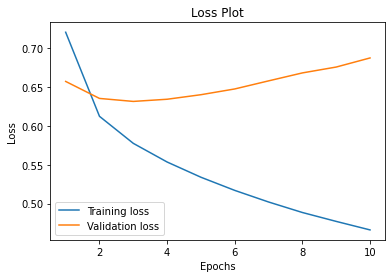

In [ ]:
train_model('MobileNetV2')

In [ ]:
evaluate_model_on_validation_set('MobileNetV2')

100%|██████████| 5000/5000 [15:14<00:00,  5.47it/s]


loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 58258, 'reflen': 52330, 'guess': [58258, 53258, 48258, 43259], 'correct': [23939, 7526, 2150, 587]}
ratio: 1.1132811007070302
Bleu_1: 0.411
Bleu_2: 0.241
Bleu_3: 0.137
Bleu_4: 0.077
computing METEOR score...
METEOR: 0.139
computing Rouge score...
ROUGE_L: 0.320
computing CIDEr score...
CIDEr: 0.209
computing SPICE score...
SPICE: 0.068

Bleu_1: 0.4109
Bleu_2: 0.2410
Bleu_3: 0.1373
Bleu_4: 0.0770
METEOR: 0.1386
ROUGE_L: 0.3200
CIDEr: 0.2088
SPICE: 0.0685


In [ ]:
evaluate_model_on_validation_image('MobileNetV2')

Predicted caption: a skateboarder is on a street with a skate board on a corner subway airline serious face <end>


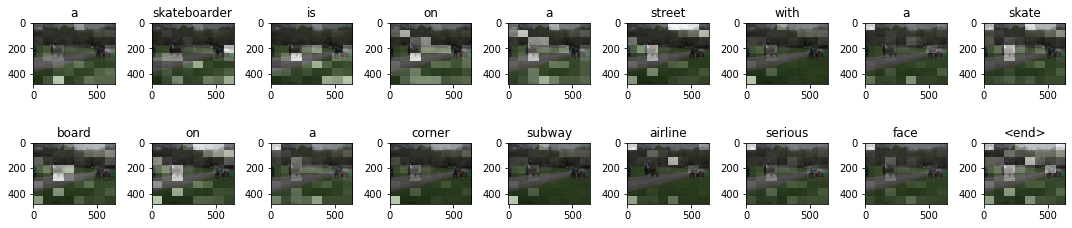

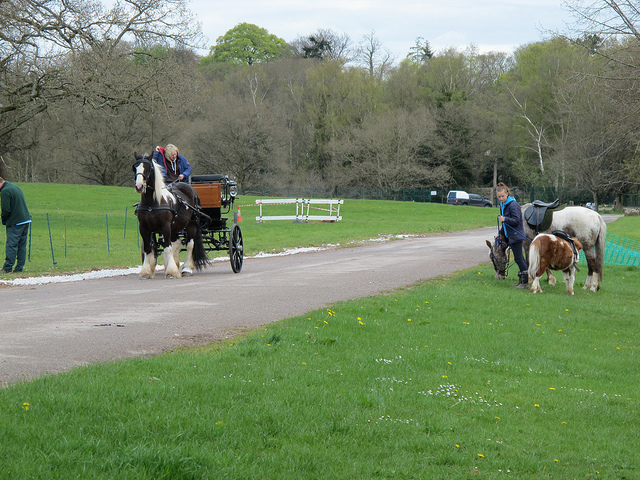

In [ ]:
evaluate_model_on_test_image('MobileNetV2')

Predicted caption: man riding pink surfboard riding the surf with a wave <end>


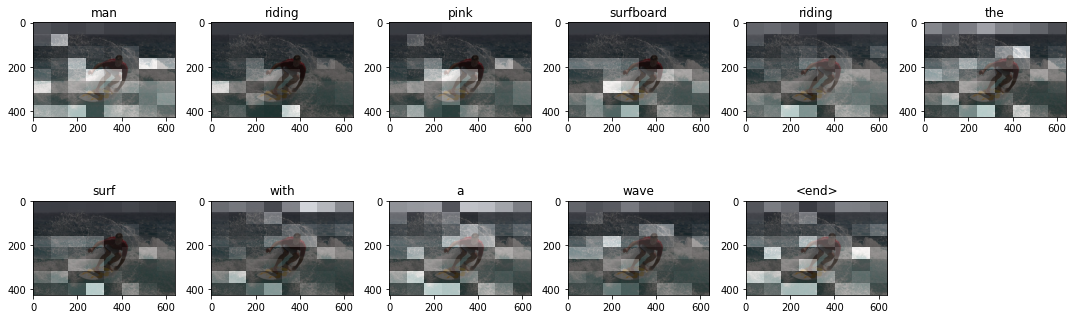

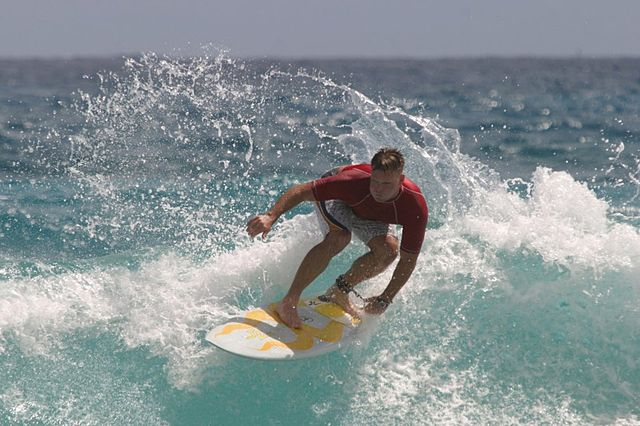

In [ ]:
evaluate_model_on_surf_image('MobileNetV2')

## 4 Final Results

### 4.1 Scores

In [ ]:
def plot_results(df, ylabel, width, size):
    labels = [x[0][1] for x in df]
    x = np.arange(len(labels))

    fig, ax = plt.subplots()
    scores_len = len(df[0][1:])
    for i in range(scores_len):
        score_label = df[0][i+1][0]
        scores = [x[i+1][1] for x in df]
        rects = ax.bar(x+(i-scores_len//2)*width, scores, width, label=score_label)

    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    fig.set_size_inches(size[0], size[1])

    plt.show()

In [ ]:
import pandas as pd

scores = [[x[0]] + x[2:-1] for x in results]
df_columns = [x[0] for x in scores[0]]
df_data = [dict(x) for x in scores]
pd.DataFrame(df_data, columns=df_columns)

Model    Bleu_1    Bleu_2  ...   ROUGE_L     CIDEr     SPICE
0           Xception  0.421541  0.245838  ...  0.330608  0.233267  0.073404
1              VGG16  0.397974  0.230636  ...  0.314538  0.183141  0.065224
2        ResNet152V2  0.422991  0.250846  ...  0.326327  0.229942  0.073523
3        InceptionV3  0.412557  0.240692  ...  0.321480  0.225188  0.072497
4  InceptionResNetV2  0.416964  0.247984  ...  0.324261  0.221461  0.072427
5        MobileNetV2  0.410914  0.240971  ...  0.320011  0.208805  0.068497

[6 rows x 9 columns]

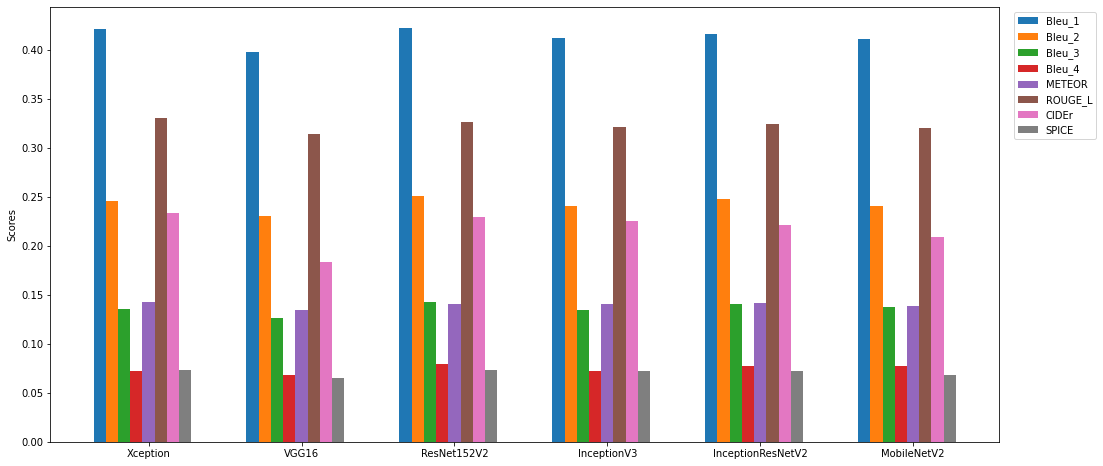

In [ ]:
plot_results(scores, 'Scores', 0.08, (17, 8))

### 4.2 Times

#### 4.2.1 Training

In [ ]:
training_times = [x[0:2] for x in results]
df_columns = [x[0] for x in training_times[0]]
df_data = [dict(x) for x in training_times]
pd.DataFrame(df_data, columns=df_columns)

Model  Training time
0           Xception    6897.514382
1              VGG16    5486.567877
2        ResNet152V2    6199.127721
3        InceptionV3    5283.941976
4  InceptionResNetV2    4952.930323
5        MobileNetV2    5023.308659

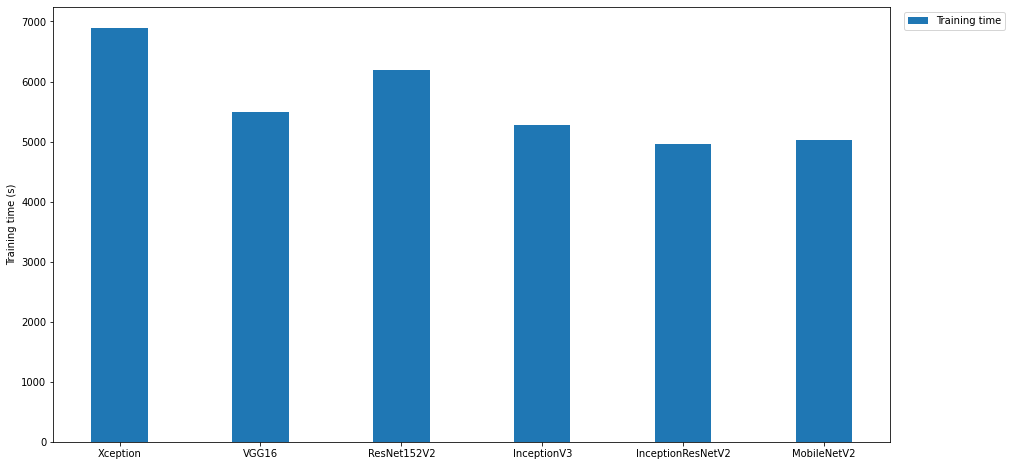

In [ ]:
plot_results(training_times, 'Training time (s)', 0.4, (15, 8))

#### 4.2.2 Prediction

In [ ]:
prediction_times = [[x[0]] + [x[-1]] for x in results]
df_columns = [x[0] for x in prediction_times[0]]
df_data = [dict(x) for x in prediction_times]
pd.DataFrame(df_data, columns=df_columns)

Model  Prediction time
0           Xception         0.246181
1              VGG16         0.123981
2        ResNet152V2         0.249910
3        InceptionV3         0.212838
4  InceptionResNetV2         0.300193
5        MobileNetV2         0.204292

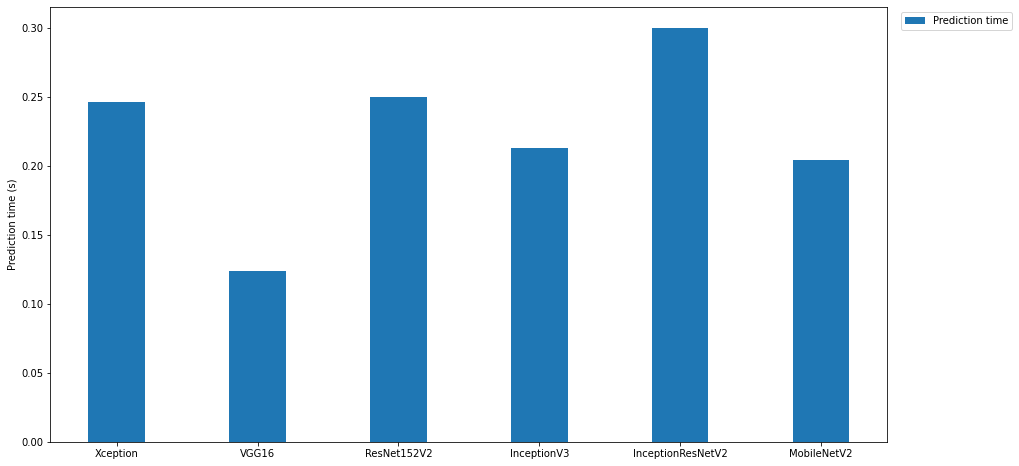

In [ ]:
plot_results(prediction_times, 'Prediction time (s)', 0.4, (15, 8))

## 5 References

1. Dataset: https://cocodataset.org/#home
2. Tutorial: https://www.tensorflow.org/tutorials/text/image_captioning
3. Evaluation metrics: https://pypi.org/project/pycocoevalcap/


